# DentalAnywhere Image Recognition System

## Dataset

Source of dataset: 
https://cs.uef.fi/pub/color/spectra/ODSI-DB/ and https://www.kaggle.com/shivam17299/oral-cancer-lips-and-tongue-images
Dataset is obtained from the above URLs. 

There is a total of 309 images used which are label with 12 classes as follows:

- AttritionErosion  
- Calculus   
- Dentine_caries  
- Gingivitis  
- Inflammation  
- Initial_caries
- Leukoplakia  
- Microfracture  
- Plague  
- Ulcer  
- Healthy  
- Cancer

In [1]:
# import necessary libraries
import os
import zipfile
import cv2
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.optimizers import RMSprop
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from sklearn import preprocessing

In [2]:
# Load image files and append them as array
dataset=[]
datalabel=[]

rootdir= r"C:\Users\ZENBOOK\Documents\Hackathon\MLDADeepLearningWeek2021\OralData"

for subdir, dirs, files in os.walk(rootdir):
    for file in files:
        img=cv2.imread(os.path.join(subdir, file))
        resized=cv2.resize(img,(512,512))
        dataset.append(resized)
        datalabel.append(subdir[70:])

dataset=tf.convert_to_tensor(dataset)
dataset

<tf.Tensor: shape=(309, 512, 512, 3), dtype=int32, numpy=
array([[[[ 81,  87, 124],
         [ 80,  86, 123],
         [ 79,  85, 122],
         ...,
         [ 58,  59, 103],
         [ 58,  59, 103],
         [ 57,  59, 100]],

        [[ 77,  82, 121],
         [ 77,  83, 120],
         [ 77,  82, 121],
         ...,
         [ 60,  60, 106],
         [ 59,  60, 104],
         [ 58,  60, 101]],

        [[ 76,  80, 121],
         [ 75,  80, 119],
         [ 76,  78, 119],
         ...,
         [ 59,  62, 107],
         [ 58,  61, 105],
         [ 58,  61, 105]],

        ...,

        [[ 12,   4,   5],
         [ 13,   5,   6],
         [ 14,   6,   7],
         ...,
         [111,  81,  76],
         [109,  78,  75],
         [108,  77,  74]],

        [[ 14,   6,   7],
         [ 13,   5,   6],
         [ 13,   5,   6],
         ...,
         [110,  80,  75],
         [109,  78,  75],
         [106,  77,  73]],

        [[ 13,   5,   6],
         [ 13,   5,   6],
         [ 14,  

In [3]:
# Create a set of unique class for datalabel
unique_labels=set(datalabel)
unique_keys=set()
for i in range(1, len(unique_labels)+1,1):
    unique_keys.add(i)
unique_dict=dict(zip(unique_labels,unique_keys))

datalabel_numeric=[]
idx=1
for label in datalabel:
    if label in unique_dict:
        datalabel_numeric.append(unique_dict[label])
        
# Perform onehot encoding to the datalabel
datalabel_onehot=tf.one_hot(datalabel_numeric,len(unique_labels))
datalabel_onehot

<tf.Tensor: shape=(309, 12), dtype=float32, numpy=
array([[0., 0., 0., ..., 0., 0., 1.],
       [0., 0., 0., ..., 0., 0., 1.],
       [0., 0., 0., ..., 0., 0., 1.],
       ...,
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.]], dtype=float32)>

Comment: One-hot encoding is applied to ensure there is no relationship exists among the categorical variables. In other words, the assumption of the higher the categorical value, the better the category does not valid.

In [4]:
import numpy as np
from sklearn.model_selection import StratifiedShuffleSplit

x = dataset
y = datalabel_onehot

# Perform random splitting using StratifiedShuffleSplit method
sss = StratifiedShuffleSplit(n_splits=5, test_size=0.1, random_state=0)
sss.get_n_splits(x,y)
print(sss)

for train_index, test_index in sss.split(x,y):
    x1 = train_index
    x2 = test_index

x_train = tf.gather(x, indices=x1)
x_test = tf.gather(x, indices=x2)
y_train = tf.gather(y, indices=x1)
y_test = tf.gather(y, indices=x2)

StratifiedShuffleSplit(n_splits=5, random_state=0, test_size=0.1,
            train_size=None)


## Transfer Learning

Due to limited data available to train the model, VGG16 pretrained model was deployed for transfer learning. With the use of the pretrained model, we were able to leverage the previous learnings of the model on a much larger dataset. This reduces the computational cost of training the model from scatch and allows our model to perform better and is more generalised. Other pretrained models including InceptionV3 and ResNet50 were also used to train our model but VGG16 was selected as it yielded the best result among the others. 

In [5]:
from tensorflow.keras.applications.vgg16 import VGG16

base_model = VGG16(input_shape = (512, 512, 3), # Shape of our images
include_top = False, # Leave out the last fully connected layer
weights = 'imagenet')

In [6]:
i = 0
for layer in base_model.layers[:15]:
    i += 1
    layer.trainable = False
    
print(i)

15


In [7]:
# Flatten the output layer to 1 dimension
x = tf.keras.layers.Flatten()(base_model.output)

# Add a fully connected layer with 64 hidden units and ReLU activation
x = tf.keras.layers.Dense(64, activation='relu')(x)

# Add a dropout rate of 0.2
x = tf.keras.layers.Dropout(0.2)(x)

# Add a final sigmoid layer with 12 nodes for classification output
x = tf.keras.layers.Dense(len(unique_labels), activation='softmax')(x)

model = tf.keras.models.Model(base_model.input, x)

model.compile(optimizer = tf.keras.optimizers.RMSprop(learning_rate=0.0001), loss = 'categorical_crossentropy',metrics = ['acc'])

In [8]:
model.summary()

Model: "functional_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 512, 512, 3)]     0         
_________________________________________________________________
block1_conv1 (Conv2D)        (None, 512, 512, 64)      1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, 512, 512, 64)      36928     
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, 256, 256, 64)      0         
_________________________________________________________________
block2_conv1 (Conv2D)        (None, 256, 256, 128)     73856     
_________________________________________________________________
block2_conv2 (Conv2D)        (None, 256, 256, 128)     147584    
_________________________________________________________________
block2_pool (MaxPooling2D)   (None, 128, 128, 128)    

In [9]:
train_datagen = ImageDataGenerator(rescale=1./255)

train_generator = train_datagen.flow(x_train, y_train,
                                     batch_size=10)

validation_datagen = ImageDataGenerator(rescale=1./255)
      
validation_generator = validation_datagen.flow(x_test,y_test,
                                               batch_size=10)

In [11]:
history = model.fit(train_generator,
                    epochs=10,
                    validation_data=validation_generator)

Epoch 1/10
28/28 [==============================] - 333s 12s/step - loss: 1.6015 - acc: 0.3309 - val_loss: 1.4352 - val_acc: 0.3226
Epoch 2/10
28/28 [==============================] - 351s 13s/step - loss: 1.4975 - acc: 0.3597 - val_loss: 1.4290 - val_acc: 0.4516
Epoch 3/10
28/28 [==============================] - 352s 13s/step - loss: 1.2761 - acc: 0.4424 - val_loss: 1.2154 - val_acc: 0.4516
Epoch 4/10
28/28 [==============================] - 354s 13s/step - loss: 1.1959 - acc: 0.4676 - val_loss: 1.1193 - val_acc: 0.4839
Epoch 5/10
28/28 [==============================] - 350s 13s/step - loss: 1.0041 - acc: 0.5468 - val_loss: 1.0631 - val_acc: 0.5484
Epoch 6/10
28/28 [==============================] - 359s 13s/step - loss: 0.9417 - acc: 0.5576 - val_loss: 0.9500 - val_acc: 0.5806
Epoch 7/10
28/28 [==============================] - 355s 13s/step - loss: 0.8818 - acc: 0.5647 - val_loss: 1.0466 - val_acc: 0.5161
Epoch 8/10
28/28 [==============================] - 349s 12s/step - loss: 0.

## Plot of training and validation accuracy and loss

Text(0.5, 1.0, 'Training and validation loss')

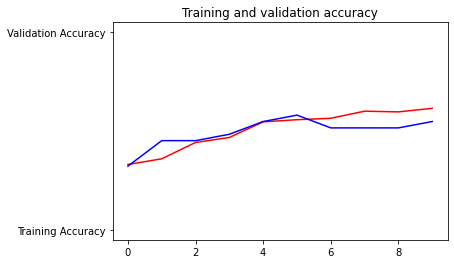

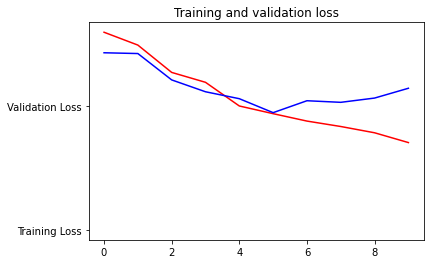

In [12]:
import matplotlib.image  as mpimg
import matplotlib.pyplot as plt

# Retrieve a list of list results on training and test datasets for each training epoch
acc=history.history['acc']
val_acc=history.history['val_acc']
loss=history.history['loss']
val_loss=history.history['val_loss']

epochs=range(len(acc)) # Get number of epochs


# Plot training and validation accuracy per epoch
plt.plot(epochs, acc, 'r', "Training Accuracy")
plt.plot(epochs, val_acc, 'b', "Validation Accuracy")
plt.title('Training and validation accuracy')
plt.figure()


# Plot training and validation loss per epoch
plt.plot(epochs, loss, 'r', "Training Loss")
plt.plot(epochs, val_loss, 'b', "Validation Loss")


plt.title('Training and validation loss')

Based on the graph above, the training accuracy increases with smaller loss as number of epochs increases, inferring that the model is learning from the training data. At the 10th epoch, training accuracy of about 60% is obtained. However, the validation accuracy remains relatively constant with larger loss as number of epochs increases. This could be a sign of overfitting due to the small training data which causes the model to only learn the features of the training data, and hence less generalised to new data.

### Possible improvement:
- Larger dataset could be used to train the data for better model accuracy
- Better data quality which potrays the distinguishable features of each oral condition may also improve model performance

## Prediction using new data

In [18]:
import matplotlib.image as mpimg
from tensorflow.keras.preprocessing import image

path = 'TrialData/Trial01' 
img = image.load_img(path, target_size=(512, 512))
x = image.img_to_array(img)
x = np.expand_dims(x, axis=0)
y_pred = model.predict(x)
y_pred
y_test

FileNotFoundError: [Errno 2] No such file or directory: 'TrialData/Trial01'

In [ ]:
def decode(pred,top=3):
    return sorted(zip(pred[0],unique_labels),reverse=True)[:top]

In [ ]:
y_pred = decode(y_pred)
y_test = decode(y_test)